In [ ]:
# Install the nexessary packages
%pip install kagglehub
%pip install matplotlib
%pip install scikit-learn
%pip install imbalanced-learn
%pip install xgboost



[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


# Step #1 - Download and load the data

We begin by downloading the dataset from Kaggle and inspecting its contents to understand the file structure and get a first look at the data.

In [ ]:
import kagglehub
import pandas as pd
import os

# Download the data and load to dataframe
path = kagglehub.dataset_download("mlg-ulb/creditcardfraud")
df = pd.read_csv(os.path.join(path, 'creditcard.csv'))
df.head()


# Step #2 - Exploritory Data Analysis (EDA)

The dataset contains features V1 through V28, which are the result of a PCA transformation done to anonymize sensitive data. Because of this, we can't interpret them directly. Our EDA will focus on the non-anonymized features: Time, Amount, and our target variable, Class.

Understanding the patterns in these features is crucial for making informed decisions about our modeling strategy.

Fraud Patterns Over Time
Let's start by visualizing the transactions to see if there are any obvious patterns related to time and transaction amount. We will plot all transactions, highlighting the fraudulent ones in red to ensure they are visible despite being a tiny minority of the data.

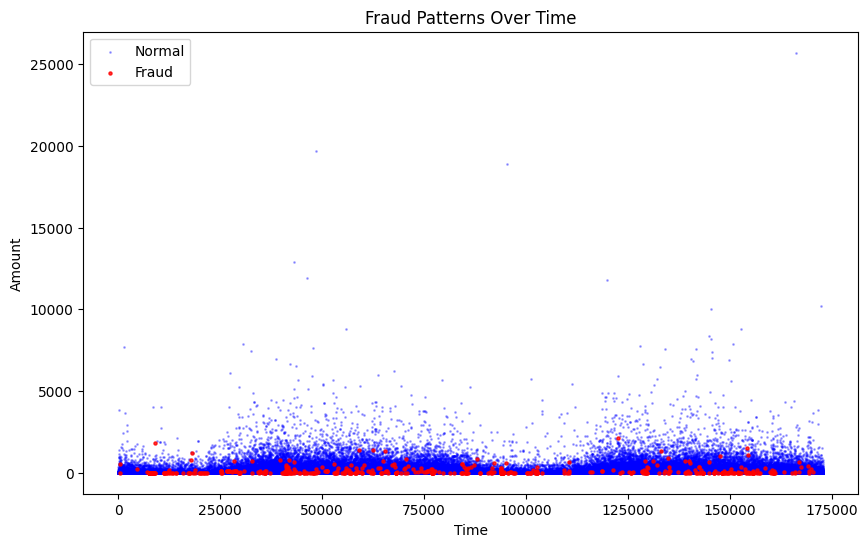

In [5]:
import matplotlib.pyplot as plt

# Separate the data by class
normal = df[df['Class'] == 0]
fraud = df[df['Class'] == 1]

plt.figure(figsize=(10, 6))
# Plot normal transactions first (background)
plt.scatter(normal["Time"], normal["Amount"], c='blue', alpha=0.3, label='Normal', s=1)
# Plot fraud transactions on top (foreground)
plt.scatter(fraud["Time"], fraud["Amount"], c='red', alpha=0.8, label='Fraud', s=5)

plt.title("Fraud Patterns Over Time")
plt.xlabel("Time")
plt.ylabel("Amount")
plt.legend()
plt.show()

Distribution of Class Values
Next, let's examine the distribution of our target variable, Class. This is a critical step because our goal is to predict this field accurately. A '1' indicates fraud, while a '0' indicates a legitimate transaction.

A significant imbalance between these classes can heavily influence our modeling strategy. As we've noted, if the fraud class is too small, a naive model could achieve high accuracy by simply predicting 'legit' for every transaction. We need to be aware of this to choose appropriate evaluation metrics and sampling techniques.

Count of records in each category in the Class field
Class
0    284315
1       492
Name: count, dtype: int64
Percent of records in each category in the Class field
Class
0    99.83
1     0.17
Name: proportion, dtype: float64


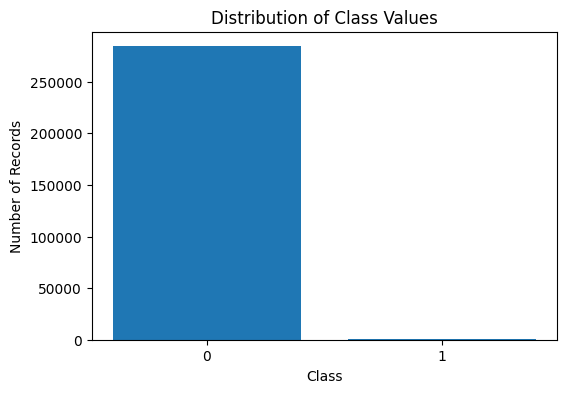

In [9]:
# Count the values in the Class column
print("Count of records in each category in the Class field")
class_counts = df['Class'].value_counts()
print(class_counts)

print("Percent of records in each category in the Class field")
class_percentages = df['Class'].value_counts(normalize=True) * 100
print(class_percentages.round(2))


plt.figure(figsize=(6, 4))
plt.bar(class_counts.index, class_counts.values)
plt.xlabel('Class')
plt.ylabel('Number of Records')
plt.title('Distribution of Class Values')
plt.xticks(class_counts.index)  # Ensure both class labels show
plt.show()

## Interpretation of EDA 
The distribution of the Class variable is the most critical insight from our EDA. With fraudulent transactions making up only 0.17% of the data, we have a severe class imbalance.

This confirms that accuracy will be a misleading metric for model evaluation. Instead, we must focus on metrics like Precision-Recall AUC and use techniques like SMOTE to handle the imbalance during training. The data appears clean and ready for the next steps.

# Step #3 - Data Processing

To prepare the data for modeling, we will perform two key steps:

Split the data into training and testing sets. We use stratify=y to ensure that the proportion of fraudulent transactions is the same in both sets. This is crucial for evaluating a model on an imbalanced dataset.

Scale the data. We will scale the Time and Amount columns using StandardScaler. This standardizes features to have a mean of 0 and a standard deviation of 1, which helps many machine learning models perform better.

In [10]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

X = df.drop("Class", axis=1)
y = df["Class"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

scaler = StandardScaler()
X_train[["Amount", "Time"]] = scaler.fit_transform(X_train[["Amount", "Time"]])
X_test[["Amount", "Time"]] = scaler.transform(X_test[["Amount", "Time"]])

# Step #4 - Adjust for Imbalance in 'Class' Field. 

As identified in our EDA, the training data is highly imbalanced, we calculated just 0.17% of transactions that have the fraud indicator, an amount that is not significant enough to train a solid model. To address this, we will use an oversampling technique to create a more balanced dataset for the model to train on.

We will use Borderline-SMOTE, a sophisticated variant of SMOTE that focuses on creating synthetic samples along the decision boundary between the two classes.

Important: This resampling is applied only to the training data (X_train, y_train) to prevent data leakage. Our model will still be evaluated on the original, untouched test set.

This code prints the before and after sample size to show the impact to the training sample, fraudulent transactions increase from 0.17% of the sample to 4.75% of the sample. A significant increase to the amount of training data.

In [11]:

from imblearn.over_sampling import SMOTE, BorderlineSMOTE 

print("Original distribution:")
print(y_train.value_counts(dropna=False))
print(f"Share of fraud before resampling: {y_train.mean()*100:.5f}%\n")

smote = BorderlineSMOTE(
    sampling_strategy=0.05,
    k_neighbors=3,
    random_state=42
)

# resample training split only
X_res, y_res = smote.fit_resample(X_train, y_train)

# quick sanity check 
print("Class distribution after resampling:")
print(y_res.value_counts(dropna=False))
print("\nShare of fraud after resampling: "
      f"{(y_res.mean()*100):.2f}%")

Original distribution:
Class
0    227451
1       394
Name: count, dtype: int64
Share of fraud before resampling: 0.17292%

Class distribution after resampling:
Class
0    227451
1     11372
Name: count, dtype: int64

Share of fraud after resampling: 4.76%


# Step #5 - Train and Test the Models

Now, we will train three different classification models on our preprocessed and resampled data. We'll evaluate them on the original, unseen test set to see how well they generalize.

Our key evaluation metric will be:
- **Precision-Recall AUC (PR-AUC)**: This is the most important metric for highly imbalanced datasets, as it focuses on the performance of how well the model balances identifying fraud without selecting false positive (flase alert).

In [12]:
# ── libs ─────────────────────────────────────────────────────────────
import numpy as np
import pandas as pd

from sklearn.linear_model   import LogisticRegression
from sklearn.ensemble       import RandomForestClassifier
import xgboost as xgb

from sklearn.metrics import (
    average_precision_score,
    roc_auc_score,
    precision_recall_curve,
    classification_report
)

# ── 1️⃣  model definitions (unchanged) ───────────────────────────────
models = {
    "Logistic": LogisticRegression(
        max_iter=3000, 
        penalty="elasticnet", 
        solver="saga",
        l1_ratio=0.2,   
        C=0.5,  
        class_weight="balanced", 
        n_jobs=-1),

    "RandomForest": RandomForestClassifier(
        n_estimators=600, 
        max_depth=10,
        class_weight="balanced_subsample", 
        random_state=42),

    "XGBoost": xgb.XGBClassifier(
        n_estimators=400, 
        max_depth=4, 
        learning_rate=0.05,
        scale_pos_weight=20, 
        eval_metric="aucpr", 
        random_state=42)
}

# ── containers for plotting later ───────────────────────────────
results   = []          # list of dicts, one per model
curves    = {}          # model name ➜ (precision, recall)

# ── train / evaluate / store everything ─────────────────────────
for name, clf in models.items():
    clf.fit(X_res, y_res)                # train on BorderlineSMOTE output

    # continuous fraud scores for test data
    if hasattr(clf, "predict_proba"):
        y_score = clf.predict_proba(X_test)[:, 1]
    else:                                # some models expose only decision_function
        y_score = clf.decision_function(X_test)

    # default threshold = 0.50
    y_pred  = (y_score >= 0.50).astype(int)

    # metrics
    pr_auc  = average_precision_score(y_test, y_score)
    roc_auc = roc_auc_score(y_test, y_score)
    prec, rec, thr = precision_recall_curve(y_test, y_score)

    # stash for charts
    curves[name] = (prec, rec)
    results.append({
        "model"      : name,
        "clf"        : clf,
        "y_score"    : y_score,
        "y_pred"     : y_pred,
        "precision"  : prec,
        "recall"     : rec,
        "thresholds" : thr,
        "pr_auc"     : pr_auc,
        "roc_auc"    : roc_auc
    })

    # console summary
    print(f"\n── {name} ─────────────────────────────────────")
    print(f"PR-AUC  : {pr_auc:.4f}")
    print(f"ROC-AUC : {roc_auc:.4f}")
    print(classification_report(y_test, y_pred, digits=4))

/Users/scottlabbe/.pyenv/versions/3.12.8/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/scottlabbe/.pyenv/versions/3.12.8/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/scottlabbe/.pyenv/versions/3.12.8/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b



── Logistic ─────────────────────────────────────
PR-AUC  : 0.7133
ROC-AUC : 0.9610
              precision    recall  f1-score   support

           0     0.9998    0.9872    0.9935     56864
           1     0.1076    0.8980    0.1921        98

    accuracy                         0.9870     56962
   macro avg     0.5537    0.9426    0.5928     56962
weighted avg     0.9983    0.9870    0.9921     56962


── RandomForest ─────────────────────────────────────
PR-AUC  : 0.8162
ROC-AUC : 0.9815
              precision    recall  f1-score   support

           0     0.9997    0.9989    0.9993     56864
           1     0.5704    0.8265    0.6750        98

    accuracy                         0.9986     56962
   macro avg     0.7851    0.9127    0.8372     56962
weighted avg     0.9990    0.9986    0.9988     56962


── XGBoost ─────────────────────────────────────
PR-AUC  : 0.8630
ROC-AUC : 0.9738
              precision    recall  f1-score   support

           0     0.9998    0.9993

# Step #6 - Interpretation

The XGBoost classifier is the clear winner for this task.

While all models did a respectable job of identifying fraudulent transactions (high recall), the Logistic Regression model would be unusable in a real-world scenario due to its flood of false positives. The RandomForest model offers a good balance, but the XGBoost model is superior.

It successfully identifies a very high percentage of fraud while ensuring that the alerts it generates are trustworthy and actionable. From a business perspective, this means a more effective fraud detection system with lower operational costs and a better customer experience.

# Step #7 - Plot the testing results

Precision-Recall Curve
This first chart is going to show the trade off between precision and recall, which is also the trade off between catching all fraud and minimizing annoying customers with fraud alerts. 

The X-axis shows Recall, what percentage of fraud did we actually catch. As we move to the right, the accuracy for identifying fraudulent transactions increases and each line starts going down and different rates. As the line starts going down, we're seeing that the model is also identifying more false positives, causing the Precision (Y-axis) to decrease. 

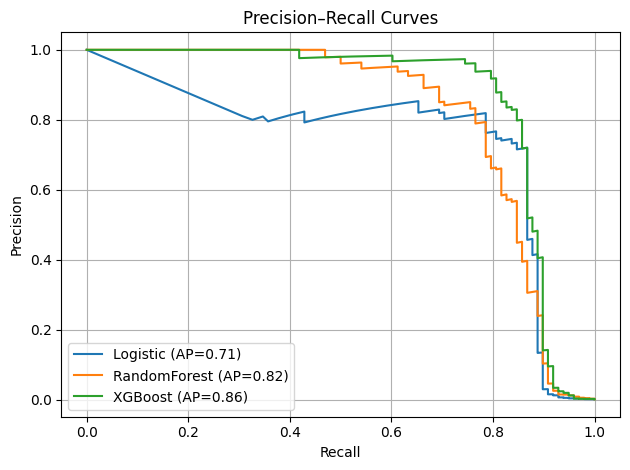

In [13]:
import matplotlib.pyplot as plt

plt.figure()
for res in results:
    plt.plot(res["recall"], res["precision"],
             label=f'{res["model"]} (AP={res["pr_auc"]:.2f})')

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curves")
plt.legend()
plt.grid(True)
plt.tight_layout()

Alerts vs. Fraud Caught 
To evaluate the testing in terms of business impact, we can view how many transactions were flagged correctly and incorrectly to see the impact on the team that investigates these situations. 

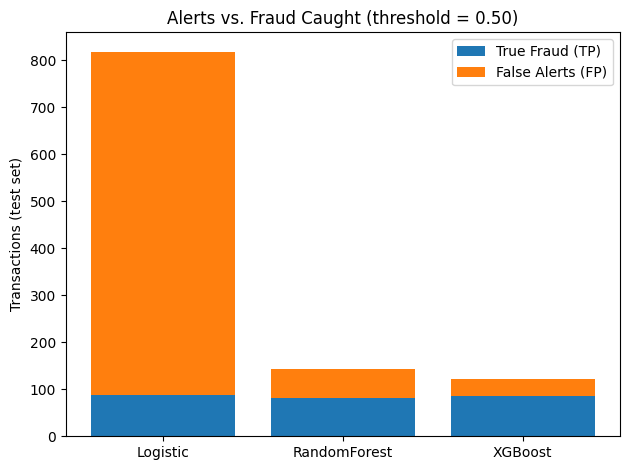

In [14]:
tp_list, fp_list, labels = [], [], []
for res in results:
    tp = ((res["y_pred"] == 1) & (y_test == 1)).sum()
    fp = ((res["y_pred"] == 1) & (y_test == 0)).sum()
    tp_list.append(tp); fp_list.append(fp); labels.append(res["model"])

x = np.arange(len(labels))
plt.figure()
plt.bar(x, tp_list, label="True Fraud (TP)")
plt.bar(x, fp_list, bottom=tp_list, label="False Alerts (FP)")
plt.xticks(x, labels)
plt.ylabel("Transactions (test set)")
plt.title("Alerts vs. Fraud Caught (threshold = 0.50)")
plt.legend()
plt.tight_layout()